# Sentiment analysis on IMDB movie reviews using GloVe word embeddings and deep LSTM network

This is a draft only showing the ability to convert an example of an IMDB movie review into a vectorized representation using a 50-dimensional GloVe word embedding

# Imports

In [1]:
# Deep Learning
from keras.models import Model
from keras.layers import LSTM, Dropout, Input, Activation, Embedding, Dense, GRU
from keras.preprocessing import sequence
from keras.initializers import glorot_uniform
from keras.callbacks import ModelCheckpoint, EarlyStopping

# Data Viz
import matplotlib.pyplot as plt

# Linear Algebra
import numpy as np

# Regex
import re

# File manipulation
import glob, os

# Shuffle data
import random

Using TensorFlow backend.


In [2]:
%matplotlib inline

# Load the IMDB dataset
Dataset can be downloaded here: http://ai.stanford.edu/~amaas/data/sentiment/

In [3]:
# def load_dataset():
#     '''
#     Loads the training and testing examples.
#     '''
    
#     # Load the training set
    
#     pos_train = glob.glob("/floyd/input/imdb/train/pos/*.txt")
#     neg_train = glob.glob("/floyd/input/imdb/train/neg/*.txt")
    
#     X_train = sorted(pos_train + neg_train)

#     # Load the testing set
    
#     pos_test = glob.glob("/floyd/input/imdb/test/pos/*.txt")
#     neg_test = glob.glob("/floyd/input/imdb/test/neg/*.txt")

#     X_test = sorted(pos_test + neg_test)
    
#     # Generate the labels
    
#     Y_train = []
#     Y_test = []
    
#     for file in X_train:
#         Y_train.append(int(file.split("/")[-1].split("_")[1].split('.')[0]))
        
#     for file in X_test:
#         Y_test.append(int(file.split("/")[-1].split("_")[1].split('.')[0]))
        
#     return (X_train, Y_train), (X_test, Y_test)

In [4]:
def load_dataset():
    '''
    Loads the training and testing examples.
    '''
    
    # Load the training set
    
    pos_train = glob.glob("/floyd/input/imdb/train/pos/*.txt")
    neg_train = glob.glob("/floyd/input/imdb/train/neg/*.txt")
    
    X_train = sorted(pos_train + neg_train)

    # Load the testing set
    
    pos_test = glob.glob("/floyd/input/imdb/test/pos/*.txt")
    neg_test = glob.glob("/floyd/input/imdb/test/neg/*.txt")

    X_test = sorted(pos_test + neg_test)
    
    # Generate the labels
    
    Y_train = []
    Y_test = []
    
    for file in X_train:
        if int(file.split("/")[-1].split("_")[1].split('.')[0]) > 5:
            Y_train.append(1)
        else:
            Y_train.append(0)
        
    for file in X_test:
        if int(file.split("/")[-1].split("_")[1].split('.')[0]) > 5:
            Y_test.append(1)
        else:
            Y_test.append(0)
    
    return (X_train, Y_train), (X_test[:12500], Y_test[:12500]), (X_test[12500:], Y_test[12500:])

In [5]:
(X_train, Y_train), (X_val, Y_val), (X_test, Y_test) = load_dataset()

In [6]:
print(len(X_train))
print(len(X_val))
print(len(X_test))

25000
12500
12500


# Load 50 dimensional GloVe word embeddings

GloVe word embeddings can be downloaded here: https://nlp.stanford.edu/projects/glove/

In [7]:
def read_glove_vecs(glove_file):
    '''
    Imports the GloVe embedding matrix from an external file and creates several interfaces to that data
    '''
    with open(glove_file, 'r', encoding="utf8") as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)
        
        i = 1
        word_to_index = {}
        index_to_word = {}
        for w in sorted(words):
            word_to_index[w] = i
            index_to_word[i] = w
            i = i + 1
    return word_to_index, index_to_word, word_to_vec_map

In [8]:
glove_path = "/floyd/input/imdb/glove.6B.50d.txt"

In [9]:
word_to_index, index_to_word, word_to_vec_map = read_glove_vecs(glove_path)

# Word embedding Example

In [10]:
word = "embedding"
try:
    print(word,'\n', word_to_vec_map[word])
except:
    print(word, " not found")

embedding 
 [ 0.62345   0.032983  0.43996   0.44996   0.85634   0.10575   0.9867
 -1.1748    0.28233   0.11164   0.14791  -0.33504  -0.54567  -0.48938
 -0.30864   0.0542    0.51353   0.25094   0.90265  -0.44953  -0.19574
 -0.059456 -0.23541   0.47732   0.14565   0.71205   0.10384   0.38435
  0.28728  -0.62065   0.19764  -0.92376  -0.45941  -0.35899  -0.36896
 -0.022755  0.036052 -0.037406 -0.6725    0.96637   1.3847   -0.22727
 -0.21122   0.47012  -0.37961  -1.0339    0.93388   0.60006  -0.36329
 -0.078399]


# Data Cleaning Procedures

In [11]:
def remove_html(text):
    '''
    Removes all html tags from input text
    '''
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', text)
    return cleantext

In [12]:
def separate_punctuation(text):
    '''
    Adds spaces around all punctation to ensure that they get tokenized properly 
    by the .split() function later on
    '''
    return text.replace("'", "").replace(","," , ") \
    .replace("."," . ").replace("!", " ! ").replace("?", " ? ")

In [13]:
def is_word_known(word):
    '''
    Determines whether the input word relates to a valid GloVe word embedding
    '''
    try:
        _ = word_to_vec_map[word]
        return True
    except:
        return False

In [14]:
def remove_unknown_words(text):
    '''
    Removes all words from the text not related to a valid GloVe word embedding
    '''
    return [word for word in text if is_word_known(word)]

In [15]:
def clean_example(review):
    '''
    Input: A movie review
    Output: A clean tokenized list of words and punctuation extracted from the movie review. 
    '''
    return remove_unknown_words(separate_punctuation(remove_html(review)).lower().split())

# Find Longest Review

We do this so we know how much to pad our other examples

In [16]:
def find_longest_review(X_train, X_val, X_test):
    '''
    Returns the amount of tokens in the longest review. (Tokens: words and punctation)
    '''

    max_len = 0
    for file in X_train + X_val + X_test:
        with open(file, 'r', encoding="utf8") as file:
            max_len = max(max_len, len(clean_example(file.read())))

    return max_len

In [17]:
max_len = find_longest_review(X_train, X_val, X_test)

In [18]:
print(max_len)

2627


## Define the model

In [19]:
def glove_embedding_layer(word_to_vec_map, word_to_index):
    '''
    Returns a Keras embedding layer populated with 50-dimensional GloVe word embeddings
    '''
    # Define dimensions of embedding matrix
    vocab_len = len(word_to_index) + 1
    emb_dim = word_to_vec_map["embedding"].shape[0]
    
    # Initialize empty matrix
    emb_matrix = np.zeros((vocab_len, emb_dim))
    
    # Populate embedding matrix
    for word, index in word_to_index.items():
        emb_matrix[index, :] = word_to_vec_map[word]

    # Build Embedding layer
    embedding_layer = Embedding(input_dim=vocab_len, output_dim=emb_dim, trainable=False)
    embedding_layer.build((None,))
    embedding_layer.set_weights([emb_matrix])
    
    return embedding_layer

In [20]:
def lstm_network(input_shape, word_to_vec_map, word_to_index):
    '''
    Returns keras model of the neural network
    '''
    # Input Layer
    sentence_indices = Input(shape=input_shape, dtype="int32")
    
    # Embedding layer
    embedding_layer = glove_embedding_layer(word_to_vec_map, word_to_index)
    embeddings = embedding_layer(sentence_indices)   
    
    # LSTM layers
#     X = LSTM(64, return_sequences=True)(embeddings)
#     X = Dropout(rate=0.5)(X)
#     X = LSTM(64, return_sequences=False)(X)
#     X = Dropout(rate=0.5)(X)

#     X = LSTM(64, return_sequences=True)(embeddings)
#     X = Dropout(rate=0.5)(X)
    X = LSTM(128, return_sequences=False)(embeddings)
    X = Dropout(rate=0.5)(X)
        
    
    # Output layer
    X = Dense(1, activation="sigmoid")(X)
    
    model = Model(inputs=sentence_indices, outputs=X)
    
    return model

In [21]:
model = lstm_network((100,), word_to_vec_map, word_to_index)
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['acc'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 100, 50)           20000050  
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               91648     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 20,091,827
Trainable params: 91,777
Non-trainable params: 20,000,050
_________________________________________________________________


# Generate Mini-Batches

In [22]:
def sentences_to_indices(X, word_to_index, max_len):
    '''
    Input: A list of reviews containing the complete text of a movie review
    Output: A list of reviews containing the indices to the GloVe embedding 
        matrix for each word in the original review
    '''
    m = X.shape[0]

    X_indices = np.zeros([m, max_len])
    
    for i in range(m):
        
        j = 0
        sentence_words = clean_example(X[i])
        
        # Trim the sentence if max_len requires it
        sentence_words = sentence_words[:max_len]

        for w in sentence_words:
            X_indices[i, j] = word_to_index[w]
            j = j + 1
    
    return X_indices

In [23]:
def generator(filenames, labels, batch_size, word_to_index, max_len):
    '''
    Generates next mini-batch of data each time this function is called
    '''
    file_count = len(filenames)
    batch_count = 0

    # Shuffle Data
    c = list(zip(filenames, labels))
    random.shuffle(c)
    filenames, labels = zip(*c)
    
    steps_per_epoch = len(filenames)//batch_size
    
    while True:
        
        beg = batch_count * batch_size
        end = beg + batch_size
        
        # Generate mini-batch features
        batch_features = []
        for file in filenames[beg:end]:
            with open(file, 'r', encoding="utf8") as f:
                batch_features.append(f.read())
        
        batch_features = sentences_to_indices(np.array(batch_features), word_to_index, max_len)
        
        # Generate mini-batch labels
        batch_labels = np.array(labels[beg:end])
        
        # Prepare for next batch
        batch_count = (batch_count + 1) % steps_per_epoch
        
        yield batch_features, batch_labels

# Train the Model

In [24]:
batch_size = 256
max_len = 100
epochs = 50
early_stopping_patience = 5

In [25]:
callbacks_list = [
    ModelCheckpoint("final_weights.h5", monitor='val_acc', verbose=1, save_best_only=True),
    EarlyStopping(monitor='val_acc', patience=early_stopping_patience, verbose=0)
]

history = model.fit_generator(generator(X_train, Y_train, batch_size, word_to_index, max_len), \
                    steps_per_epoch=len(X_train)//batch_size, \
                    epochs=epochs, \
                    validation_data=generator(X_val, Y_val, batch_size, word_to_index, max_len), \
                    callbacks=callbacks_list, \
                    validation_steps=len(X_val)//batch_size)

Epoch 1/50
97/97 [==============================] - 26s 264ms/step - loss: 0.2263 - acc: 0.6219 - val_loss: 0.2309 - val_acc: 0.5998

Epoch 00001: val_acc improved from -inf to 0.59977, saving model to final_weights.h5
Epoch 2/50
97/97 [==============================] - 21s 220ms/step - loss: 0.1940 - acc: 0.7084 - val_loss: 0.2181 - val_acc: 0.6476

Epoch 00002: val_acc improved from 0.59977 to 0.64762, saving model to final_weights.h5
Epoch 3/50
97/97 [==============================] - 21s 218ms/step - loss: 0.1813 - acc: 0.7337 - val_loss: 0.2667 - val_acc: 0.5270

Epoch 00003: val_acc did not improve from 0.64762
Epoch 4/50
97/97 [==============================] - 21s 218ms/step - loss: 0.1724 - acc: 0.7490 - val_loss: 0.2311 - val_acc: 0.6126

Epoch 00004: val_acc did not improve from 0.64762
Epoch 5/50
97/97 [==============================] - 21s 218ms/step - loss: 0.1648 - acc: 0.7608 - val_loss: 0.1924 - val_acc: 0.6992

Epoch 00005: val_acc improved from 0.64762 to 0.69922, sa

# Evaluate

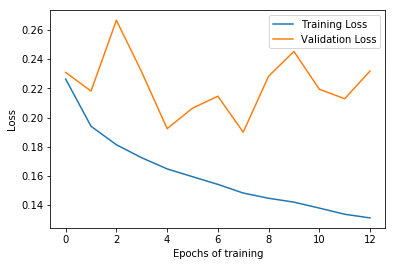

In [26]:
plt.plot(history.history['loss'], label="Training Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.legend(loc='best')
plt.xlabel("Epochs of training")
plt.ylabel("Loss")
plt.show()

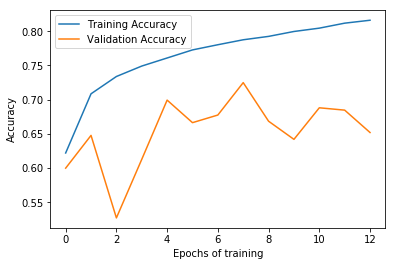

In [27]:
plt.plot(history.history['acc'], label="Training Accuracy")
plt.plot(history.history['val_acc'], label="Validation Accuracy")
plt.legend(loc='best')
plt.xlabel("Epochs of training")
plt.ylabel("Accuracy")
plt.show()

In [28]:
preds = model.evaluate_generator(generator=generator(X_test,Y_test, batch_size, word_to_index, max_len), steps=len(X_test)/batch_size)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

Loss = 0.07670337052977814
Test Accuracy = 0.9060108418367347
